# Project Part 2 Solutions

Name: 

Lu Han, 5371943

Judy Zhu, 3024270


## (a)

In [164]:
import numpy as np

file=np.load("part2.npz")
beta_old=file['beta_old']
N=file['N']
Svc_0_PMF=file['Svc_0_PMF']
Lc=file['Lc']
Ic_0=file['Ic_0']
gamma=file['gamma']
L_observed=file['L_observed']
nb_nodes = Svc_0_PMF.shape[0]

Svc_0_PMF

array([[[1.84256271e-02, 1.91694422e-02, 1.62480032e-02, 1.12200254e-02],
        [8.56835292e-02, 8.30312882e-02, 6.55525409e-02, 4.21638838e-02],
        [1.43017452e-01, 1.29089434e-01, 9.49282958e-02, 5.68727194e-02],
        [8.56835292e-02, 7.20371033e-02, 4.93421944e-02, 2.75349316e-02]],

       [[1.74219928e-02, 1.95339743e-02, 1.77274987e-02, 1.30217208e-02],
        [8.50878057e-02, 8.54583950e-02, 6.94714251e-02, 4.57111082e-02],
        [1.44363418e-01, 1.29879076e-01, 9.45769469e-02, 5.57436573e-02],
        [8.50878057e-02, 6.85715527e-02, 4.47285387e-02, 2.36150845e-02]],

       [[8.73809911e-02, 9.17693779e-02, 7.71052668e-02, 5.18293470e-02],
        [1.52634735e-01, 1.36523086e-01, 9.76931804e-02, 5.59278130e-02],
        [8.73809911e-02, 6.65643324e-02, 4.05668821e-02, 1.97791268e-02],
        [1.63948608e-02, 1.06366347e-02, 5.52085308e-03, 2.29252231e-03]],

       ...,

       [[7.72717648e-03, 1.27301717e-02, 1.66347103e-02, 1.72410527e-02],
        [5.32123916

In [165]:
def SIR(t, Z, N, betas, gamma):
    (S_vec, I_vec, R) = (Z[:16].reshape(4, 4), Z[16:20], Z[-1])
    I = I_vec.sum()
    dSdt = -betas*S_vec*I/N 
    dIdt = -dSdt.sum(axis=0)-gamma*I_vec
    dRdt = np.array([gamma*I])
    return np.concatenate((dSdt.flatten(), dIdt, dRdt))

In [166]:
from scipy.integrate import solve_ivp
from scipy.optimize import fmin
from sklearn.metrics import mean_squared_error

Svc_0_PMF /= Svc_0_PMF.sum(axis=(1, 2), keepdims=True)
Svc_0 = (N-Ic_0.sum(axis=1))[:, np.newaxis, np.newaxis]*Svc_0_PMF
Svc_0 = Svc_0.round().astype(int)
R0 = np.zeros((nb_nodes)).astype(int)

t = np.linspace(0, 199, 200)

S = np.zeros((nb_nodes, 4, 4, len(t)))
I = np.zeros((nb_nodes, 4, len(t)))
R = np.zeros((nb_nodes, len(t)))
L = np.zeros((nb_nodes, len(t)))

for N_node, node_index in zip(N, range(nb_nodes)):

    initial_conditions = np.concatenate(
        (Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))

    soln = solve_ivp(
        SIR, (t[0], t[9]), initial_conditions, args=(N_node, beta_old, gamma), t_eval=t[:10])

    S[node_index, :, :, :10] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, :10] = soln.y[16:20]
    R[node_index, :10] = soln.y[20]
    L[node_index, :10] = Lc@soln.y[16:20]


alpha_predicted = np.zeros((nb_nodes))


def loss_func(alpha):
    new_initial_conditions = np.concatenate((S[node_index,:,:,9].flatten(), I[node_index,:,9], [R[node_index,9]]))
    soln = solve_ivp(
        SIR, (t[9],t[30]), new_initial_conditions,args=(N_node,beta_old*alpha,gamma),t_eval=t[9:30])

    S[node_index, :, :, 9:30] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, 9:30] = soln.y[16:20]
    R[node_index, 9:30] = soln.y[20]
    L[node_index, 9:30] = Lc@soln.y[16:20]
    mse = mean_squared_error(L_observed[node_index, 9:30], L[node_index][9:30])
    return mse

for N_node, node_index in zip(N, range(nb_nodes)):
    alpha_predicted[node_index] = fmin(loss_func, 0.5, disp=False)

print("Sorted alpha values are ", np.sort(alpha_predicted),'\n')
print("Indexes of nodes sorted by alpha values are", np.argsort(alpha_predicted))

Sorted alpha values are  [0.13437347 0.14959717 0.15996704 0.16158829 0.16306152 0.16851807
 0.17086182 0.17155762 0.17612305 0.17961426 0.18221436 0.18603516
 0.18710937 0.19025879 0.20031738 0.20330505 0.20419922 0.20612793
 0.20684509 0.2128418  0.21408691 0.2162323  0.21859131 0.22739258
 0.23042603 0.23352203 0.24157715 0.24465332 0.24894104 0.25119629
 0.25798035 0.25991821 0.26757812 0.26948242 0.27169952 0.27301636
 0.28005524 0.28283691 0.28662109 0.28800049 0.2930542  0.2992981
 0.29938354 0.30321045 0.30422821 0.30437317 0.30966797 0.31420898
 0.32382202 0.3296875  0.32988281 0.33074341 0.33313293 0.33355408
 0.3498291  0.35234375 0.35657806 0.35756836 0.35844421 0.36207275
 0.36960449 0.37071838 0.37946777 0.38393707 0.3860054  0.39033203
 0.40922546 0.41445465 0.41787415 0.41876221 0.42476807 0.43438721
 0.43756104 0.44870605 0.44996338 0.45647888 0.47091064 0.48615723
 0.5023941  0.50705566 0.50830688 0.52108459 0.53604736 0.55296021
 0.55423279 0.56278687 0.58075714 0.59

## (b)

In [167]:
def g(money):
    alpha = 1/np.log2(2*10**(-3)*money+2)
    return alpha

def g_inv(alpha):
    money = (2**(1/alpha)-2)/(2*10**(-3))
    return money

def scatter_plot(alpha_afterNPI):
    plt.figure()
    colors=(beta_old[np.newaxis,:,:]*Svc_0_PMF).mean(axis=(1,2))
    plt.scatter(alpha_predicted, alpha_afterNPI, s=N/500, c=colors, cmap='jet', alpha=0.5)
    plt.xlabel(r"$\alpha_{own}$")
    plt.ylabel(r"$\alpha_{after\ NPI}$")

def total_recovered_difference(alpha_afterNPI):
    # difference between the summation of people recovered after 200 days 
    # in all the nodes using alpha_afterNPI or using old alpha after Day 30.
    difference = 0
    for N_node, node_index in zip(N, range(nb_nodes)):
        i_conditions = np.concatenate((S[node_index,:,:,29].flatten(), I[node_index,:,29], [R[node_index,29]]))
        soln_alpha_old = solve_ivp(SIR, (t[29],t[199]), i_conditions,args=(N_node,beta_old*alpha_predicted[node_index],gamma),t_eval=t[29:199])
        soln_alpha_new = solve_ivp(SIR, (t[29],t[199]), i_conditions,args=(N_node,beta_old*alpha_afterNPI[node_index],gamma),t_eval=t[29:199])
        difference += soln_alpha_old.y[-1][-1] - soln_alpha_new.y[-1][-1]  # number of recovered population on last day
    return difference

def calculate_alpha_after(alpha_own, money):
    return g(g_inv(alpha_own)+money)

### Policy #1

i. Larger alpha_own gives larger alpha_after, so the trend of the slopes are the same. The first graph is just alpha_own(alpha_predicted) vs. itself. Compared the first and second graph, we can see the smaller the original alpha_own are, the steeper slope its corresponding alpha_after_NPI points have at becaused the delta_alpha (caculated solely based on money) is the same. The latter two graphs both represent alpha_after_NPI vs. alpha_own after policy 1.

ii.

When applying policy 1, total recovered difference is  320300.82569705904


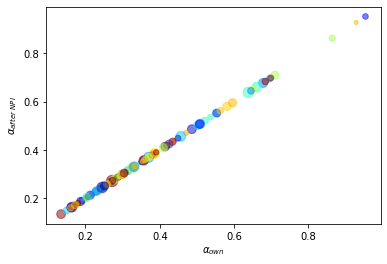

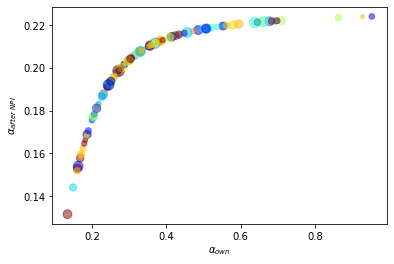

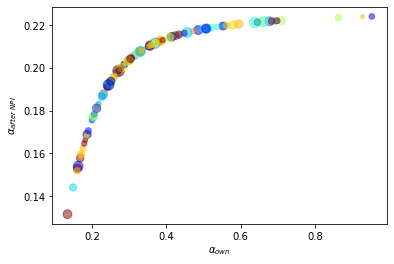

In [205]:
import matplotlib.pyplot as plt
import copy

# original plot
scatter_plot(alpha_predicted)

alpha_policy1 = copy.deepcopy(alpha_predicted)
for i, v in enumerate(alpha_predicted):
    alpha_policy1[i] = calculate_alpha_after(v, 10000)

# policy 1 plot
scatter_plot(alpha_policy1)
# basically the same as policy 1 plot, g(g_inv(alpha_predicted)+10000) is the same as the sum of calculate_alpha_after(i, 10000)
scatter_plot(g(g_inv(alpha_predicted)+10000))
print("When applying policy {}, total recovered difference is ".format(1), total_recovered_difference(alpha_policy1))

### Policy #2

i. 
Larger alpha_own gives larger alpha_after, so the trend of the two slopes are the same. With larger alpha_own, alpha_after would have larger variance and still follows a roughly curve. We could also see that bigger bubbles are mostly at the bottom of the whole pattern. Compared to the policy #1, the curve of policy #2 is under the same distribution but inclined to flatten. The reason is that when larger population gets more portion of money, alpha will decreases more. Thus large markers tends to decline more.

ii.

When applying policy 2, total recovered difference is  335846.7291849529


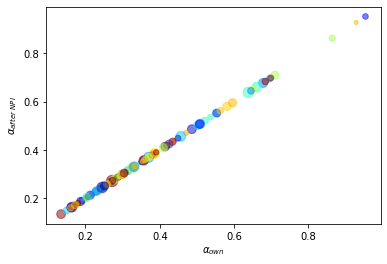

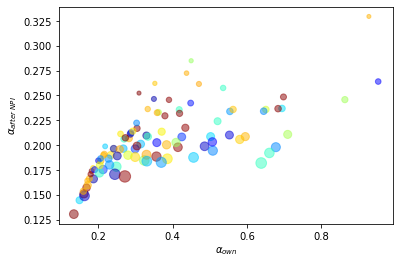

In [207]:
alpha_policy2 = copy.deepcopy(alpha_predicted)
n_portion = N/N.sum()
for i, v in enumerate(alpha_predicted):
    alpha_policy2[i] = calculate_alpha_after(v, n_portion[i]*1000000)
# original plot
scatter_plot(alpha_predicted)
# Policy 2 plot
scatter_plot(alpha_policy2)

print("When applying policy {}, total recovered difference is ".format(2), total_recovered_difference(alpha_policy2))

### Policy #3

i. The plot after policy 3 is the same as the original plot as the policy tries to make all the nodes have same (alpha_own - alpha_after_NPI) value. As (alpha_own - alpha_after_NPI) is a constant, the function becomes alpha_after_NPI = alpha_own + c. Thus the slope is always one and function is linear, which is represented as the last plot assuming c = 0.

ii.

When applying policy 3, total recovered difference is  62723.053790414306


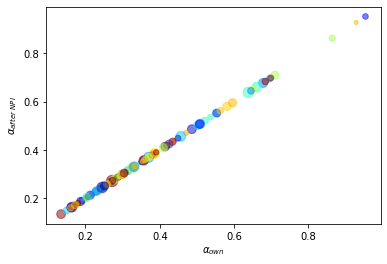

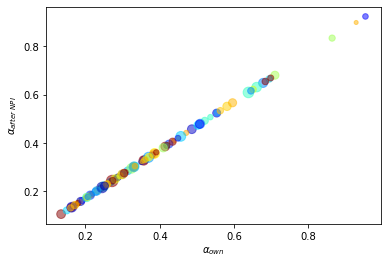

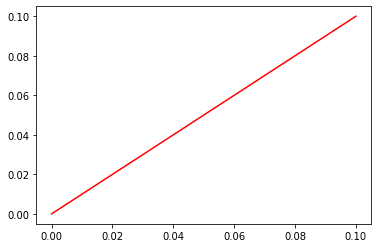

In [209]:
# original plot
scatter_plot(alpha_predicted)

alpha_policy3 = copy.deepcopy(alpha_predicted)
def diff_budget(alpha_change):
    # Go over every alpha and compute money needed to produce given delta alpha
    money_needed = 0
    budget = 1000000
    for alpha in alpha_predicted:
        money_needed += g_inv(alpha-alpha_change) - g_inv(alpha)
    
    return (money_needed - budget) ** 2 # squared so that we minimize a positive value!

alpha_change = fmin(diff_budget, 0, disp=False)

for i, v in enumerate(alpha_predicted):
    alpha_policy3[i] = v - alpha_change

print("When applying policy {}, total recovered difference is ".format(3), total_recovered_difference(alpha_policy3))
# 
scatter_plot(alpha_policy3)
# which is similar to x = y, as alpha_own - alpha_after_NPI is the same, basically alpha_own = alpha_after_NPI
fig = plt.figure()
x = np.linspace(0,0.1,100)
y = x
plt.plot(x,y, 'r')
plt.show()

### Policy #4

i. The goal of the policy is to minimize the total recovered population across nodes after 200 days as as fewer recoevered population meaning fewer susceptible population at the first place, and thus fewer mortality rate. The policy plot seems like a combination of policy 2, policy 3 and policy 5. 
1. All the alpha_after_NPI is under the slope of 1.
2. Nodes with larger population decline more.
3. Budget is somehow spent proportional to each node's average beta value weighted by the susceptible population size in comorbidity and vulnerability compartments. There're layers of colors with gradually changes.

From observation, blue large nodes are receiving most budgets because they have higher beta value and larger population(S_vc)

ii.

[ 6. 23.  8.  7. 33.  0. 14.  6.  1.  0.  5.  3. 20.  0.  0.  0.  0. 15.
  8.  0.  8.  0. 20.  0. 15.  0. 63.  0.  1. 23. 17.  4. 17.  0.  8. 32.
  0.  0.  3.  2.  4.  1. 18.  0. 47.  2.  6. 44. 33.  0.  0. 12. 18. 15.
  0.  4.  0. 13.  8. 10.  5.  1.  0.  7.  0. 45. 29.  1. 48.  0.  0. 56.
  6.  1. 18. 24.  3.  9. 10.  5.  1. 22.  0.  3. 28.  4.  0.  3.  5. 23.
  0.  0. 11. 26.  4.  0.  0.  0.  4.  1.]
When applying policy 4, total recovered difference is  338362.69153516804


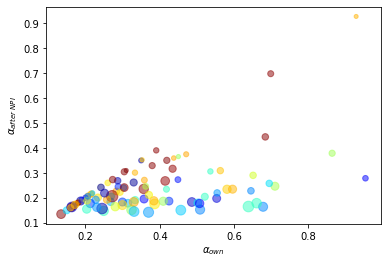

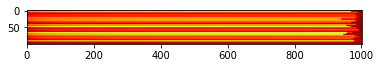

In [216]:
# policy is to minimize the total recovered population across nodes after 200 days 
# as fewer recoevered population meaning fewer susceptible population at the first place, and thus fewer mortality rate

budget = 1000000
partial_budget = 1000
money = np.zeros(nb_nodes)
nparts = int(budget/partial_budget)+1
recover_matrix = np.zeros((nb_nodes,nparts))

for node_index, v in enumerate(alpha_predicted):
  recover_matrix[node_index,0]=0
  for imoney in range(1,nparts):
    alpha_after = calculate_alpha_after(v,partial_budget*imoney)
    i_conditions = np.concatenate((S[node_index,:,:,29].flatten(), I[node_index,:,29], [R[node_index,29]]))
    soln_alpha_old = solve_ivp(SIR, (t[29],t[199]), i_conditions,args=(N_node,beta_old*v,gamma),t_eval=t[29:199])
    soln_alpha_new = solve_ivp(SIR, (t[29],t[199]), i_conditions,args=(N_node,beta_old*alpha_after,gamma),t_eval=t[29:199])
    difference = soln_alpha_new.y[-1][-1] - soln_alpha_old.y[-1][-1]  # number of recovered population on last day
    recover_matrix[node_index,imoney] = difference

# Attempt to replace the following loop:
# total_budget = 50000
# nb_budget_pieces = 1001
# while total_budget>0:
#   win_index = np.argmax(recover_matrix[:,0]-recover_matrix[:,1])  # give partial budget to whoever decrease the most susceptible population
#   recover_matrix[win_index,:-1]=recover_matrix[win_index,1:]
#   recover_matrix[win_index,-1]=0
#   money[win_index]+=1
#   total_budget-=50000/nb_budget_pieces

for i in range(1,nparts):
  win_index = np.argmax(recover_matrix[:,0]-recover_matrix[:,1])  # give partial budget to whoever decrease the most susceptible population
  recover_matrix[win_index,:-1]=recover_matrix[win_index,1:]
  recover_matrix[win_index,-1]=0
  money[win_index]+=1

print(money)

alpha_policy4 = copy.deepcopy(alpha_predicted)
for node_index, v in enumerate(alpha_predicted):
  alpha_policy4[node_index] = calculate_alpha_after(v,money[node_index]*partial_budget)

scatter_plot(alpha_policy4)
print("When applying policy {}, total recovered difference is ".format(4), total_recovered_difference(alpha_policy4))

import matplotlib.pyplot as plt 
plt.figure()
plt.imshow(recover_matrix, cmap='jet')
plt.show()

### Policy #5


i. Policy is designed to spend the budget proportional to each node's average beta value weighted by the susceptible population size in comorbidity and vulnerability compartments. Thus we can see a super clear difference in layers of colors, gradually changing from purple to brown. Diffeerent colors corrsponding to different averge beta values. In this plot, brown nodes are receiving more budgets as their beta values are higher. The slope is very similar to policy 1 as for similar beta values, we distribute similar amount of budget.

ii.

When applying policy 5, total recovered difference is  312603.48034805944


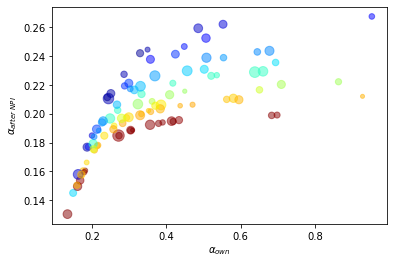

In [172]:
# policy is to spend the budget proportional to each node's average beta value weighted by the susceptible
# population size in comorbidity and vulnerability compartments.
alpha_policy5 = copy.deepcopy(alpha_predicted)
budget = 1000000
average_beta = np.zeros(100)
for i in range(100):
  average_beta[i] = sum(sum(Svc_0_PMF[i]*beta_old))

# print(average_beta)
beta_portion = average_beta/average_beta.sum()
for i, v in enumerate(alpha_predicted):
    alpha_policy5[i] = calculate_alpha_after(v, beta_portion[i]*budget)

scatter_plot(alpha_policy5)
print("When applying policy {}, total recovered difference is ".format(5), total_recovered_difference(alpha_policy5))

## (c)

[ 4  4 10  8  2  0  7  3  3  5  0  5  2  0  3  5  1  1  4  3  6  3  5  3
  6  3  2  0  0  6  9  2  0  0  0  6  3  0 11  8  3  0  9  4  6  3  2  8
  5 10  2  9  0 10  3  8  7  6  3  2  8  1  5  6  4 10  6  3  2  3  1 10
  4  8  8  4  0 10  4  4  0  2  3  0  4  3  3  6 11 11  0  4  0  2  7  2
  0  0  1  3]


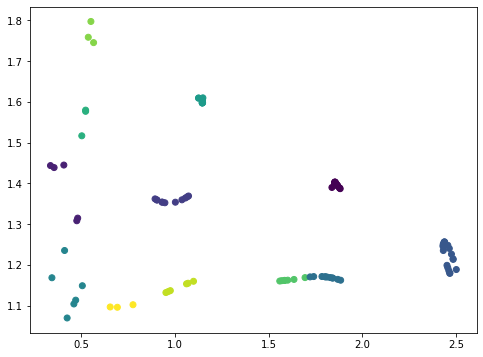

In [173]:
from scipy import ndimage
import seaborn as sns
from sklearn.cluster import KMeans

# Fairness to evaluate if nodes in the same cluster based on C and V have similar NPI actions.
# How to evaluate fairness? - Nodes should have similar budget per population with each other.
# Policy that have the smallest difference in budget per population is the fairest policy.

# First let's cluster the nodes based on their SV and/or comorbidity distribution.
cor_x = []
cor_y = []
for i in range(100):
  cor = ndimage.measurements.center_of_mass(Svc_0_PMF[i])
  cor_x.append(cor[0])
  cor_y.append(cor[1])

# K-means clustering. After observing the plot, there're about 10 major clusters.
kmeans = KMeans(n_clusters=12, random_state=0).fit(cor_arra)
labels = kmeans.labels_

# Group Number for 100 groups
print(labels)

# Visualize it:
plt.figure(figsize=(8, 6))
plt.scatter(cor_x,cor_y, c=labels.astype(float))

### Policy 1

In [182]:
#POLICY 1
diff = np.zeros((12,2))
diff[:,0]=np.Inf
diff[:,1]=-np.Inf

# Find the min and max between budget per capita in each cluster
for node_index in range(100):
  group_no = kmeans.predict(np.asarray(cor_arra[node_index]).reshape(1,-1))
  budget = g_inv(alpha_predicted[node_index]) - g_inv(alpha_policy1[node_index])
  diff[group_no[0],0] = min(diff[group_no[0],0],budget/N[node_index])
  diff[group_no[0],1] = max(diff[group_no[0],1],budget/N[node_index])
print(diff)
# find the largest_diff for the node
largest_diff = max(diff[:,1]-diff[:,0])
print(round(largest_diff,3))

[[-1.21187935 -0.24586695]
 [-0.66527724 -0.21099144]
 [-0.60150997 -0.19440522]
 [-1.18766423 -0.15239708]
 [-1.06634179 -0.20894543]
 [-0.78505344 -0.17974462]
 [-0.66379039 -0.17492613]
 [-0.57695855 -0.31105782]
 [-1.09703943 -0.21516713]
 [-0.32369223 -0.28365102]
 [-0.83248454 -0.20901308]
 [-0.62789734 -0.27971325]]
1.035


### Policy 2

In [181]:
#POLICY 2
diff = np.zeros((12,2))
diff[:,0]=np.Inf
diff[:,1]=-np.Inf

# Find the min and max between budget per capita in each cluster
for node_index in range(100):
  group_no = kmeans.predict(np.asarray(cor_arra[node_index]).reshape(1,-1))
  budget = g_inv(alpha_predicted[node_index]) - g_inv(alpha_policy2[node_index])
  diff[group_no[0],0] = min(diff[group_no[0],0],budget/N[node_index])
  diff[group_no[0],1] = max(diff[group_no[0],1],budget/N[node_index])
print(diff)
# find the largest_diff for the node
largest_diff = max(diff[:,1]-diff[:,0])
print("Fairness score is ", round(largest_diff,3))

[[-0.36842354 -0.36842354]
 [-0.36842354 -0.36842354]
 [-0.36842354 -0.36842354]
 [-0.36842354 -0.36842354]
 [-0.36842354 -0.36842354]
 [-0.36842354 -0.36842354]
 [-0.36842354 -0.36842354]
 [-0.36842354 -0.36842354]
 [-0.36842354 -0.36842354]
 [-0.36842354 -0.36842354]
 [-0.36842354 -0.36842354]
 [-0.36842354 -0.36842354]]
Fairness score is  0.0


### Policy 3

In [211]:
#POLICY 3
diff = np.zeros((12,2))
diff[:,0]=np.Inf
diff[:,1]=-np.Inf

# Find the min and max between budget per capita in each cluster
for node_index in range(100):
  group_no = kmeans.predict(np.asarray(cor_arra[node_index]).reshape(1,-1))
  budget = g_inv(alpha_predicted[node_index]) - g_inv(alpha_policy3[node_index])
  diff[group_no[0],0] = min(diff[group_no[0],0],budget/N[node_index])
  diff[group_no[0],1] = max(diff[group_no[0],1],budget/N[node_index])
print(diff)
# find the largest_diff for the node
largest_diff = max(diff[:,1]-diff[:,0])
print("Fairness score is ", round(largest_diff,3))

[[-3.10902239e+00 -2.99461422e-03]
 [-1.14577301e+00 -3.99728460e-03]
 [-4.39709987e+00 -1.60013362e-03]
 [-7.32820241e+00 -2.96916397e-03]
 [-1.78445820e+00 -3.10204167e-03]
 [-6.11419586e-01 -5.17556858e-03]
 [-3.34403884e-01 -1.39378744e-03]
 [-9.56808497e-01 -1.54713638e-02]
 [-3.60247277e-02 -1.62297200e-03]
 [-2.52417384e-01 -1.06794526e-02]
 [-6.31917978e-01 -3.47093166e-03]
 [-8.58319087e-02 -1.52101115e-03]]
Fairness score is  7.325


### Policy 4

In [210]:
#POLICY 4
diff = np.zeros((12,2))
diff[:,0]=np.Inf
diff[:,1]=-np.Inf

# Find the min and max between budget per capita in each cluster
for node_index in range(100):
  group_no = kmeans.predict(np.asarray(cor_arra[node_index]).reshape(1,-1))
  budget = g_inv(alpha_predicted[node_index]) - g_inv(alpha_policy4[node_index])
  diff[group_no[0],0] = min(diff[group_no[0],0],budget/N[node_index])
  diff[group_no[0],1] = max(diff[group_no[0],1],budget/N[node_index])
print(diff)
# find the largest_diff for the node
largest_diff = max(diff[:,1]-diff[:,0])
print("Fairness score is ", round(largest_diff,3))

[[-0.48693155  0.        ]
 [-0.46934077  0.        ]
 [-1.22475289  0.        ]
 [-0.13578232  0.        ]
 [-0.77594109  0.        ]
 [-0.59315725  0.        ]
 [-1.06239818 -0.19913712]
 [-0.43548094  0.        ]
 [-0.94673537 -0.10136824]
 [-0.58264602 -0.34038122]
 [-1.17047327  0.        ]
 [-0.64334046 -0.14740286]]
Fairness score is  1.225


### Policy 5


In [178]:
#POLICY 5
diff = np.zeros((12,2))
diff[:,0]=np.Inf
diff[:,1]=-np.Inf

# Find the min and max between budget per capita in each cluster
for node_index in range(100):
  group_no = kmeans.predict(np.asarray(cor_arra[node_index]).reshape(1,-1))
  budget = g_inv(alpha_predicted[node_index]) - g_inv(alpha_policy5[node_index])
  diff[group_no[0],0] = min(diff[group_no[0],0],budget/N[node_index])
  diff[group_no[0],1] = max(diff[group_no[0],1],budget/N[node_index])
print(diff)
# find the largest_diff for the node
largest_diff = max(diff[:,1]-diff[:,0])
print("Fairness score is ", round(largest_diff,3))

[[-1.46215656 -0.29963866]
 [-0.35349733 -0.10910602]
 [-0.43043223 -0.14430852]
 [-1.78361061 -0.22581662]
 [-1.26116976 -0.23819983]
 [-0.38308083 -0.08875817]
 [-0.58395551 -0.1546283 ]
 [-0.34353794 -0.17866985]
 [-1.10745281 -0.21590964]
 [-0.20298898 -0.18329375]
 [-0.65794509 -0.16207961]
 [-0.35352045 -0.16265411]]
Fairness score is  1.558


# Answer:

**Goal:** Our fairness metric is nodes in the same cluster based on C and V should have similar NPI actions(evalutated by maximum difference between budget per capita among nodes in the same cluster)

**Conclusion:** Policy 2 is the best because the policy is designed to distirbute budgets proportional to population, however, it might be not fair regarding distributing budgets based on Svc_pmf (or beta) of each cluster in addition to budgets per capita.

The ranking of other policys are:
Policy 1 > Policy 4 > Policy 5 > Policy 3

**Future:** If we set another metric to compare each cluster are receiving budgets depending on the its beta value in addition to all the nodes in the same cluster should receive similar budgegt per capita, then I think Policy 4 and Policy 5 will perform better according to their plots.